## Предобработка датасета

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import shapiro, normaltest
from sklearn.preprocessing import PowerTransformer, MinMaxScaler


In [3]:
def order_columns(df):
    """
    Функция упорядочивает столбцы,
    целевые признаки помещаются в конец датафрейма
    
    """
    
    df = df[['Количество отвердителя, м.%',
             'Содержание эпоксидных групп, %',
             'Температура вспышки, С',
             'Потребление смолы, г/м2',
             'Угол нашивки, град',
             'Шаг нашивки',
             'Плотность нашивки',
             'Плотность, кг/м3',
             'Поверхностная плотность, г/м2',
             'Модуль упругости, ГПа',
             'Соотношение матрица-наполнитель',
             'Модуль упругости при растяжении, ГПа',
             'Прочность при растяжении, МПа']]
    return df

### 1. Очистка от выбросов  
Воспользуемся методом межквартильного диапазона для удаления выбросов, так как этот метод подходит и для ненормально распределенных значений.

In [4]:
merged = pd.read_csv('../data/merged.csv')
merged.head()

,"Количество отвердителя, м.%","Содержание эпоксидных групп, %","Температура вспышки, С","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки,"Плотность, кг/м3","Поверхностная плотность, г/м2","Модуль упругости, ГПа",Соотношение матрица-наполнитель,"Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа"
0,30.00,22.267857,100.000000,220.0,0,4.0,57.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
1,50.00,23.750000,284.615385,220.0,0,4.0,60.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
2,49.90,33.000000,284.615385,220.0,0,4.0,70.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
3,129.00,21.250000,300.000000,220.0,0,5.0,47.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
4,111.86,22.267857,284.615385,220.0,0,5.0,57.0,2030.0,210.0,753.000000,2.771331,70.0,3000.0


In [5]:
print("Количество строк в исходном датасете -", merged.shape[0])

Количество строк в исходном датасете - 1023


In [6]:
# вычисление межквартильного диапазона
q1 = merged.quantile(0.25)
q3 = merged.quantile(0.75)
iqr = q3 - q1

# определение границ выбросов
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# удаление выбросов из датафрейма
merged = merged[~((merged < lower_bound) | (merged > upper_bound)).any(axis=1)]

# сброс индекса
merged.reset_index(drop=True, inplace=True)

print("Количество строк в очищенном датасете -", merged.shape[0])

Количество строк в очищенном датасете - 936


### 2. Приведение к нормальному распределению  
Постараемся привести данные к распределению Гаусса, так как модели регрессии лучше и точнее работают с нормально распределенными данными.

- #### Преобразование Бокса-Кокса  

Исключим из данных столбцы, не подходящие для данной нормализации:  
-Угол нашивки: вероятно имеет распределение Бернулли  
-Шаг нашивки, плотность нашивки: некоторые значения равны 0

In [7]:
data = merged.drop(columns=["Угол нашивки, град", "Шаг нашивки", "Плотность нашивки"])

In [8]:
# Преобразование Бокса-Кокса
pt = PowerTransformer(method='box-cox', standardize=False)
norm_data = pt.fit_transform(data)

# Датафрейм для хранения преобразованных данных
norm_data = pd.DataFrame(norm_data, columns=list(data))

In [9]:
def compare_hist(df, norm_df):
    """Функция, сравнивающая распределение до и после нормализации"""
    
    for column in df.columns:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))

        fig.suptitle(column)

        sns.histplot(df[column], bins=26, ax=axs[0], kde=True)
        axs[0].set_xlabel('Исходное распределение')

        sns.histplot(norm_df[column], bins=26, ax=axs[1], kde=True)
        axs[1].set_xlabel('Распределение после нормализации')
        
        plt.show()

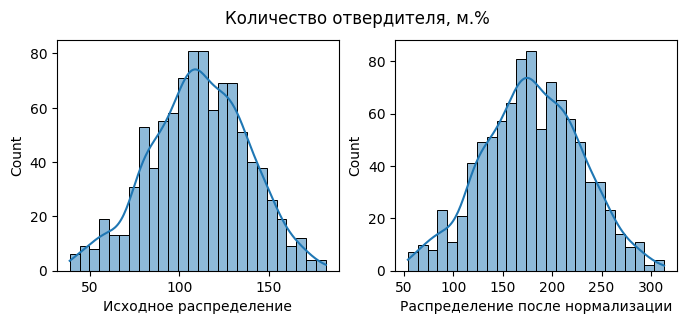

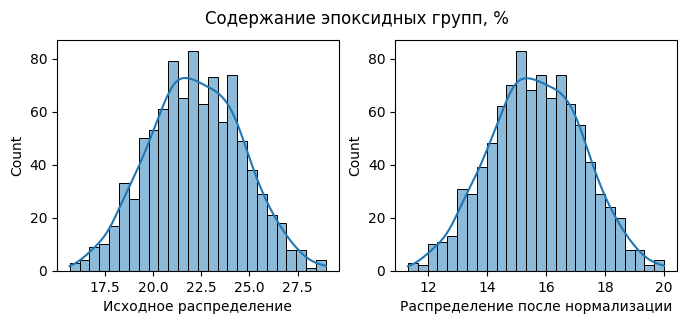

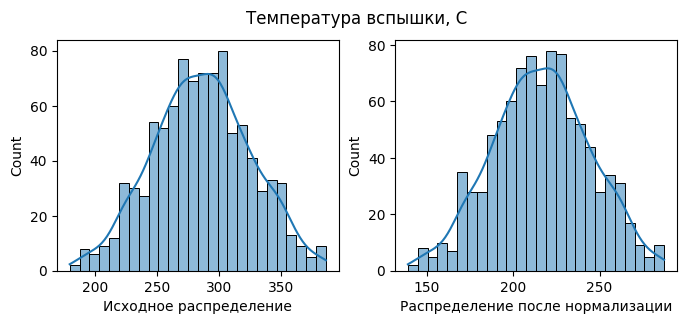

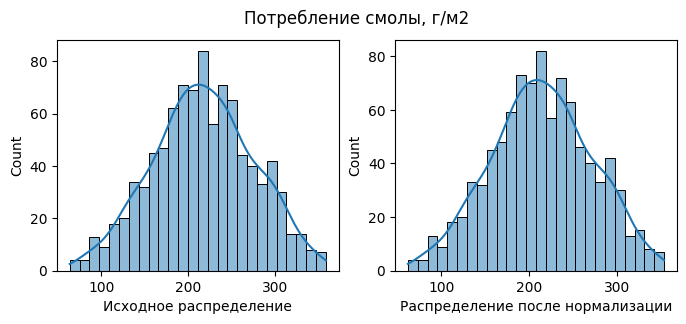

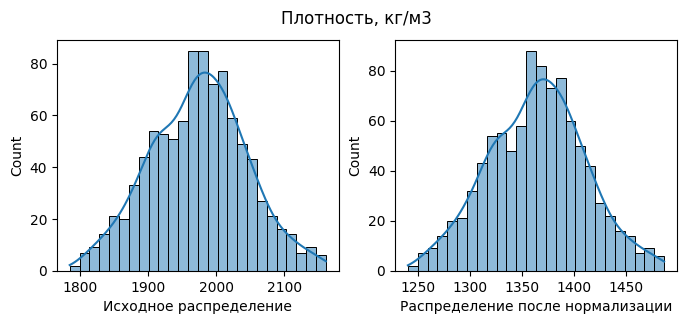

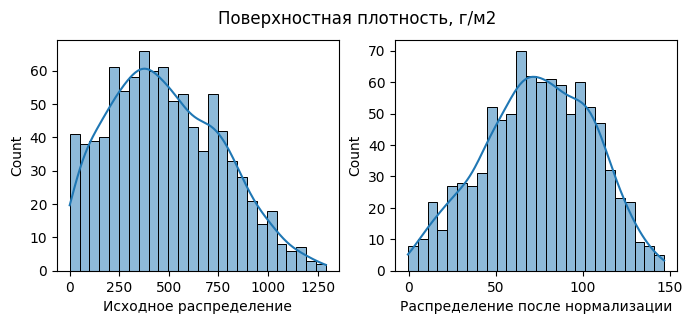

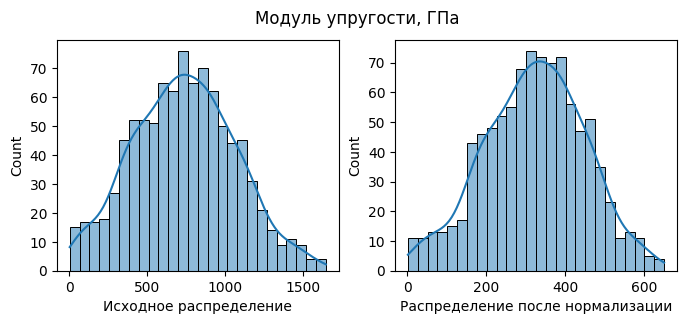

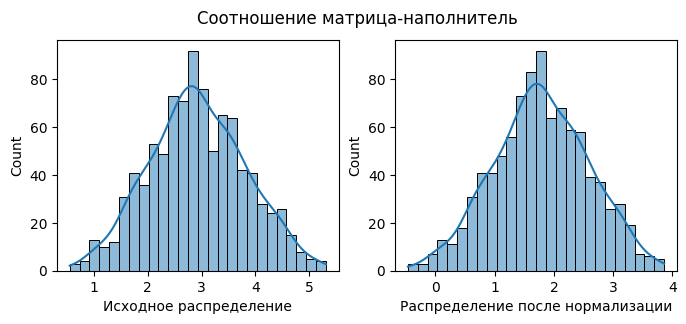

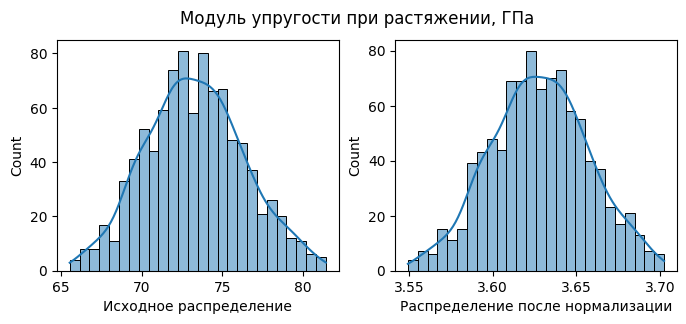

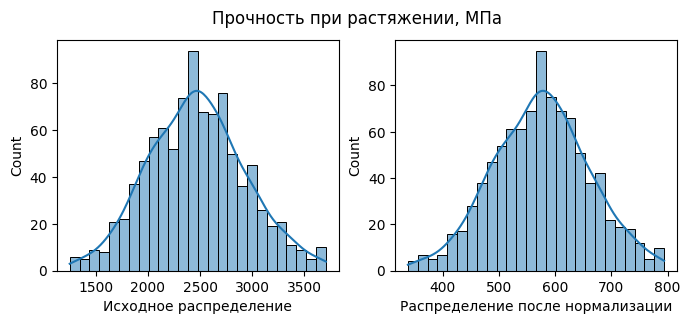

In [10]:
# Гистограммы распределения исходных и преобразованных данных
compare_hist(data, norm_data)

In [11]:
# Обратное преобразование Бокса-Кокса (для работы web-приложения)
pt.inverse_transform(norm_data)

array([[5.00000000e+01, 2.37500000e+01, 2.84615385e+02, ...,
        1.85714286e+00, 7.00000000e+01, 3.00000000e+03],
       [1.29000000e+02, 2.12500000e+01, 3.00000000e+02, ...,
        1.85714286e+00, 7.00000000e+01, 3.00000000e+03],
       [1.11860000e+02, 2.22678571e+01, 2.84615385e+02, ...,
        2.77133106e+00, 7.00000000e+01, 3.00000000e+03],
       ...,
       [1.10533477e+02, 2.39575016e+01, 2.48423047e+02, ...,
        3.28060448e+00, 7.47343437e+01, 2.66290604e+03],
       [1.41397963e+02, 1.92469447e+01, 2.75779840e+02, ...,
        3.70535121e+00, 7.40427084e+01, 2.07171586e+03],
       [1.29183416e+02, 2.74747630e+01, 3.00952708e+02, ...,
        3.80802004e+00, 7.43097040e+01, 2.85632893e+03]])

- #### Возведение в степень  

Для нормализации параметров Шаг нашивки и Плотность нашивки используем квадратный корень

In [12]:
sqrt_cols = merged[["Шаг нашивки", "Плотность нашивки"]] ** 1/2

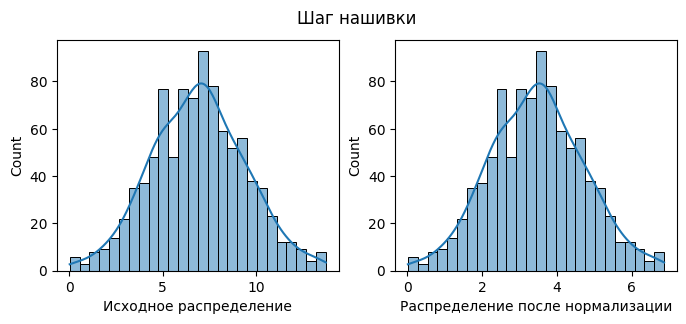

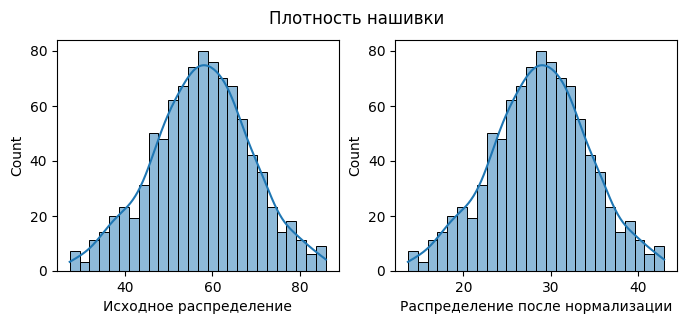

In [13]:
compare_hist(merged[["Шаг нашивки", "Плотность нашивки"]], sqrt_cols)

Визуально форма распределения не изменилась после возведения в степень 1/2. Поэтому для колонок "Шаг нашивки" и "Плотность нашивки" нормализацию применять не будем.

- #### Проверка на нормальность после нормализации

In [14]:
# собираем нормализованный датасет
data = norm_data.merge(
                       merged[["Угол нашивки, град", "Шаг нашивки", "Плотность нашивки"]],
                       left_index=True,
                       right_index=True
                       )

In [15]:
# упорядочить столбцы
data = order_columns(data)

In [16]:
# Тесты на нормальность

result_df = pd.DataFrame(columns=['pearson p-value', 'shapiro p-value'])

for column in data.columns:
    # тест по Пирсону
    _, pearson_p_value = normaltest(data[column])
    
    # тест по Шапиро-Уилку
    _, shapiro_p_value = shapiro(data[column])
    
    # записываем p-value в таблицу
    result_df.loc[column] = [round(pearson_p_value, 6), round(shapiro_p_value, 6)]

result_df

,pearson p-value,shapiro p-value
"Количество отвердителя, м.%",0.115641,0.077618
"Содержание эпоксидных групп, %",0.068529,0.259555
"Температура вспышки, С",0.091761,0.088632
"Потребление смолы, г/м2",0.013135,0.015542
"Угол нашивки, град",0.000000,0.000000
Шаг нашивки,0.638223,0.349388
Плотность нашивки,0.376078,0.052223
"Плотность, кг/м3",0.346985,0.094749
"Поверхностная плотность, г/м2",0.000000,0.000009
"Модуль упругости, ГПа",0.046403,0.011452


Таким образом, распределение параметров "Поверхностная плотность" и "Плотность нашивки" так и не удалось привести к нормальному распределению после преобразования.

### 3. Масштабирование данных  
Метод MinMaxScaler, масштабирующий данные в интервале (0,1)

In [17]:
scl = MinMaxScaler()
data_scl = pd.DataFrame(scl.fit_transform(data), columns = data.columns)
data_scl.sample(5)

,"Количество отвердителя, м.%","Содержание эпоксидных групп, %","Температура вспышки, С","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки,"Плотность, кг/м3","Поверхностная плотность, г/м2","Модуль упругости, ГПа",Соотношение матрица-наполнитель,"Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа"
521,0.612852,0.279843,0.821760,0.476657,1.0,0.016876,0.818325,0.342100,0.539812,0.423550,0.364555,0.475757,0.289605
618,0.473696,0.796559,0.541727,0.425790,1.0,0.430356,0.411324,0.095036,0.536404,0.706211,0.849955,0.631499,0.509642
574,0.563617,0.674442,0.618728,0.396485,1.0,0.599260,0.374054,0.273718,0.655878,0.757250,0.492102,0.497148,0.111426
481,0.519425,0.647897,0.737853,0.630314,1.0,0.616412,0.646776,0.320685,0.936557,0.160305,0.325991,0.904717,0.659269
412,0.900579,0.289452,0.730568,0.619950,0.0,0.689194,0.911434,0.679386,0.998688,0.381332,0.559261,0.262624,0.259658


In [18]:
data_scl.shape

(936, 13)

### 4. Сохранение  
Сохраним очищенные от выбросов данные в файл.

In [19]:
merged.to_csv('../data/clean.csv', index=False)

Сохраним очищенные от выбросов, нормализованные и отмасштабированные данные в файл.

In [20]:
data_scl.to_csv('../data/processed.csv', index=False)

[Далее](https://github.com/Svkhorol/Diploma-Project-Bauman-MSTU/blob/main/notebooks/4_Modeling.ipynb)  
[К содержанию](https://github.com/Svkhorol/Diploma-Project-Bauman-MSTU/blob/main/README.md)